<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_bigdata05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. GBM 파라미터 튜닝

In [6]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     | 46.4MB 580kB/s
     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 604kB 35.2MB/s 
     |████████████████████████████████| 3.1MB 42.1MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 296kB 38.1MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.8.0-py2.py3-none-any.whl size=259932 sha256=debfb3448aa135040d02bcbbebe626166bc00084435371e293976afb736bc99e
  Stored in directory: /tmp/pip-ephem-wheel-cache-uzty86i6/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=0beb3096012128853bceca6337b336e31297b0ab79960cbb5e88a84e15550c32
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=2919

In [1]:
# 사용자 계정 인증
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
# 데이터 불러오기(샘플링 → 100000개)
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'jeju-bigquery-282708'
client = bigquery.Client(project = 'jeju-bigquery-282708')

train = client.query('''
  SELECT 
      * 
  FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
  WHERE RAND() < 100000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
  ''').to_dataframe()

In [3]:
train

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201909,강원,속초시,한식 음식점업,강원,속초시,10s,2,1,56,1022400,78
1,202003,강원,평창군,빵 및 과자류 소매업,강원,평창군,10s,2,1,4,55850,6
2,201904,서울,중구,택시 운송업,강원,원주시,20s,2,2,694,18427670,3781
3,201904,울산,남구,한식 음식점업,강원,삼척시,20s,1,1,3,209100,10
4,201904,경기,용인시 처인구,전시 및 행사 대행업,강원,춘천시,20s,1,1,24,743050,61
...,...,...,...,...,...,...,...,...,...,...,...,...
100136,201905,충북,청주시 상당구,골프장 운영업,충북,청주시 흥덕구,70s,1,5,22,2573300,39
100137,201907,충북,제천시,기타 대형 종합 소매업,충북,단양군,70s,1,5,36,2912490,63
100138,201912,충북,청주시 상당구,빵 및 과자류 소매업,충북,청주시 청원구,70s,1,5,6,74200,7
100139,201908,충북,증평군,체인화 편의점,충북,증평군,70s,1,5,17,329750,33


In [4]:
# 데이터 시각화
from pandas_profiling import ProfileReport

profile = ProfileReport(train, title = 'Pandas Profiling Report', explorative = True)
profile.to_notebook_iframe()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# 머신러닝, 시각화, 통계 패키지 임포트
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# 통계
from scipy import stats
from scipy.stats import norm, skew

In [6]:
# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
seaborn : 0.10.1
matplotlib : 3.2.2
Python 3.6.9


In [7]:
# 날씨 데이터 전처리
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [8]:
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201909
1    202003
2    201904
3    201904
4    201904
Name: REG_YYMM, dtype: int64


In [9]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,속초시,한식 음식점업,강원,속초시,10s,2,1,56,1022400,78,2019,9
1,강원,평창군,빵 및 과자류 소매업,강원,평창군,10s,2,1,4,55850,6,2020,3
2,서울,중구,택시 운송업,강원,원주시,20s,2,2,694,18427670,3781,2019,4
3,울산,남구,한식 음식점업,강원,삼척시,20s,1,1,3,209100,10,2019,4
4,경기,용인시 처인구,전시 및 행사 대행업,강원,춘천시,20s,1,1,24,743050,61,2019,4


In [10]:
# 시군구 컬럼 제거
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [11]:
df

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,건강보조식품 소매업,강원,30s,1,2,2019,11,9,613300,9
1,강원,건강보조식품 소매업,강원,30s,1,2,2020,1,3,22000,3
2,강원,건강보조식품 소매업,강원,30s,2,2,2019,3,4,147000,5
3,강원,건강보조식품 소매업,강원,50s,2,4,2020,3,39,4147495,41
4,강원,건강보조식품 소매업,강원,60s,2,5,2019,10,12,1546000,13
...,...,...,...,...,...,...,...,...,...,...,...
74153,충북,휴양콘도 운영업,충남,30s,1,2,2019,10,3,131900,6
74154,충북,휴양콘도 운영업,충남,30s,2,2,2019,6,4,498000,7
74155,충북,휴양콘도 운영업,충북,30s,2,2,2019,1,3,138200,3
74156,충북,휴양콘도 운영업,충북,40s,1,3,2019,10,6,407700,6


In [12]:
# 라벨 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [13]:
dtypes

CARD_SIDO_NM    object
STD_CLSS_NM     object
HOM_SIDO_NM     object
AGE             object
SEX_CTGO_CD      int64
FLC              int64
year             int64
month            int64
CSTMR_CNT        int64
AMT              int64
CNT              int64
dtype: object

In [14]:
encoders

{'AGE': LabelEncoder(),
 'CARD_SIDO_NM': LabelEncoder(),
 'HOM_SIDO_NM': LabelEncoder(),
 'STD_CLSS_NM': LabelEncoder()}

In [15]:
df_num

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,0,0,0,2,1,2,2019,11,9,613300,9
1,0,0,0,2,1,2,2020,1,3,22000,3
2,0,0,0,2,2,2,2019,3,4,147000,5
3,0,0,0,4,2,4,2020,3,39,4147495,41
4,0,0,0,5,2,5,2019,10,12,1546000,13
...,...,...,...,...,...,...,...,...,...,...,...
74153,16,39,15,2,1,2,2019,10,3,131900,6
74154,16,39,15,2,2,2,2019,6,4,498000,7
74155,16,39,16,2,2,2,2019,1,3,138200,3
74156,16,39,16,3,1,3,2019,10,6,407700,6


### 데이터 셋 분리
test_size : 훈련 데이터, 테스트 데이터로 나누는 비율

random_state : 동일한 학습 / 테스트용 데이터 셋을 생성하기 위해 주어지는 난수 값(실험의 재현성)

shuffle : 데이터를 섞을 것인지를 결정. default = True(효율적인 학습 및 데이터셋 생성)

In [16]:
# 데이터셋 분리 모듈 import
from sklearn.model_selection import train_test_split

# X_data : AMT를 제외한 나머지 값들, y_data : AMT
X_data, y_data = df_num.loc[:, df_num.columns != 'AMT'], df.loc[:, df_num.columns == 'AMT']
y_target = y_data['AMT'] # y_data의 AMT 값을 종속 변수로 설정
X_data = X_data.drop(['CSTMR_CNT', 'CNT'], axis = 1) # 같이 움직이는 변수(CSTMR_CNT, CNT) 제거

# train과 test 비율을 7:3으로 설정, 데이터를 섞은 후 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 126, shuffle = True)


 mu = 3327942.35 and sigma = 21871848.47



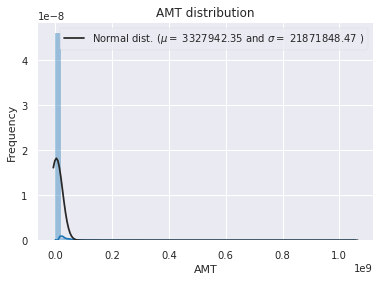

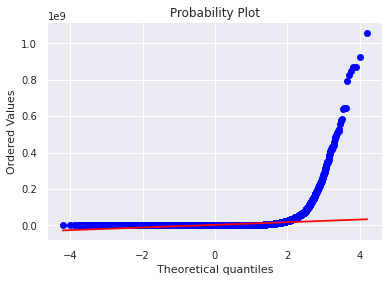

In [17]:
# 종속 변수 모양 확인
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 12.82 and sigma = 1.81



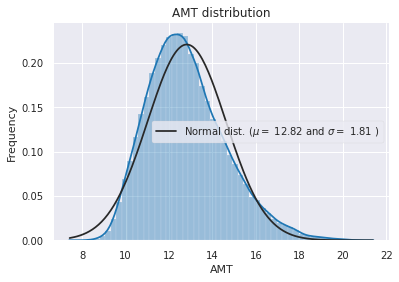

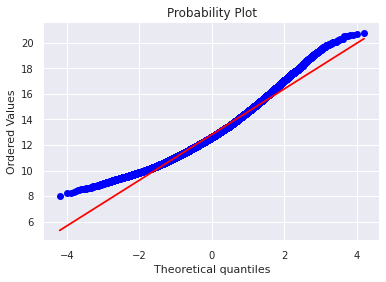

In [18]:
# 종속 변수 정규화
y_train = np.log1p(y_train)

sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

### 하이퍼 파라미터 및 튜닝
* n_estimators : weak learner가 순차적으로 오류 보정. 많을 수록 성능이 좋아지나, 수행시간이 길어짐

* learning_rate : 오차 보정 강도 제어

* max_depth : 트리의 최대 깊이 설정

* min_samples_leaf : Leaf Node가 되기 위한 최소 샘플 개수

In [19]:
# 하이퍼 파라미터 및 튜닝

# 학습
gbm = GradientBoostingRegressor(n_estimators=4000,
                                learning_rate = 0.05,
                                max_depth = 5,
                                min_samples_leaf = 5);
gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
# RMSLE 성능 평가

# 함수 생성
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('RMSLE: {0:.3f}'.format(rmsle))

In [21]:
# 예측 및 모형 평가
eval_pred = gbm.predict(X_test) # X_test를 통한 결과값 예측치
eval_pred = np.expm1(eval_pred)
rmsle(y_test, eval_pred) # RMSLE 성능 평가

RMSLE: 1.386


최종 모형을 선정할 때까지 중간 평가 지표로 삼을 것(0에 가까울수록 정밀도가 높음)

In [22]:
# 예측 템플릿 작성
from itertools import product

CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = df_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [23]:
# 예측 결과 → 데이터프레임
pred = gbm.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [24]:
# 인코딩 데이터 → 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [25]:
temp.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,4.396873e+08
1,202004,강원,골프장 운영업,1.049669e+09
2,202004,강원,과실 및 채소 소매업,1.269830e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,3.721398e+07
4,202004,강원,그외 기타 스포츠시설 운영업,3.223424e+07


In [26]:
# Submission 파일 작업 및 내보내기
submission = client.query('''
  SELECT 
    * 
  FROM `jeju-bigquery-282708.jeju_bigdata.submission` 
  ''').to_dataframe()

In [27]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)
print(submission.head())

   id  REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
0   0    202004           강원            건강보조식품 소매업  4.396873e+08
1   1    202004           강원               골프장 운영업  1.049669e+09
2   2    202004           강원           과실 및 채소 소매업  1.269830e+08
3   3    202004           강원     관광 민예품 및 선물용품 소매업  3.721398e+07
4   4    202004           강원  그외 기타 분류안된 오락관련 서비스업  0.000000e+00


In [28]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/jeju/submission05.csv', encoding='utf-8-sig', index=False)

* 파라미터 튜닝을 매번 변경하는 것이 번거로우며, 어떤 식으로 변경해야 하는지.

* RMSLE 값이 여전히 크게 나옴.

* 문제점 해결 → 교차검증, 최적의 하이퍼 파라미터 튜닝을 한 번에 진행할 필요가 있음.